### Формулировка задания
Необходимо для двух зависимых признаков оценить параметры регрессии с помощью МНК, подобрав экспериментально степень многочлена регрессии, посчитать коэффициент детерминации.
Для остатков проверить гипотезу об их гауссовости.
Добавить в выборку выбросы и оценить параметры регрессии с помощью МНК, Тьюки и Хьюбера.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy import stats
import scipy.optimize as optimize
from sklearn.metrics import mean_squared_error

Датасет выглядит следующим образом: годы (с 1895 по наше время), объем загрязнения в тоннах (состав: углекислый газ и другие вещества), среднее значение температуры. Мы хотим знать, как объем загрязнения влияет на изменение температуры Земли (важная экологическая проблема). Эти данные касаются только территории Соединенных Штатов Америки.

In [2]:
df = pd.read_csv('dt_usa_co2.csv')

In [3]:
df.head()

,year,co2_tons,mean_temp
0,1895,479.948,10.188889
1,1896,480.882,11.105556
2,1897,500.287,10.866667
3,1898,545.321,10.794444
4,1899,625.534,10.561111


Зависимость ниже приведена на рисунке:

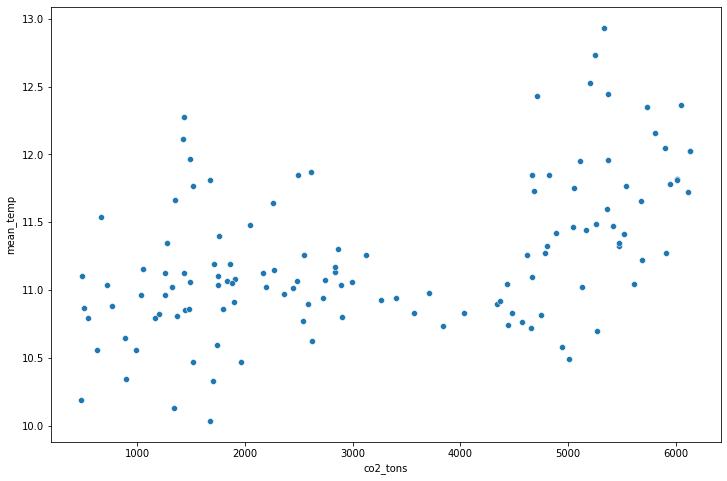

In [4]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df,x='co2_tons', y='mean_temp')

In [9]:
X = df['co2_tons'].values
y = df['mean_temp'].values

X = X/1000

Построим графики изменения объема загрязнения и среднего значения температуры по годам. По рисунку кажется, что несоответствие - например, в конце рисунка объем загрязнения упал, но температура поднялась. По-видимому, здесь наблюдается некоторая задержка (отставание) значений температуры от текущего объема загрязнения.

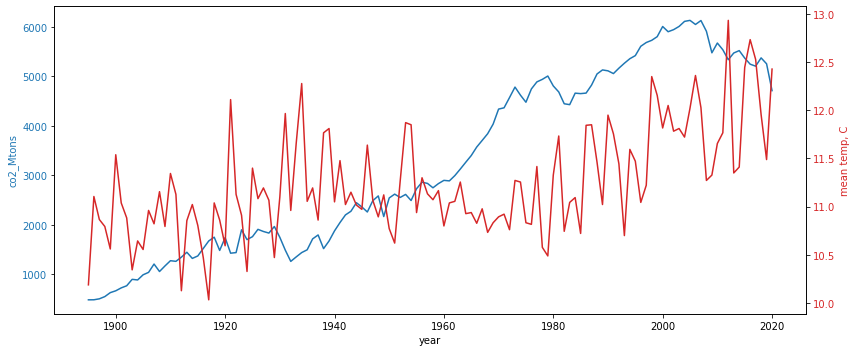

In [12]:
fig, ax1 = plt.subplots(figsize=(12, 5))

color = 'tab:blue'
ax1.set_xlabel('year')
ax1.set_ylabel('co2_Mtons', color=color)
ax1.plot(df['year'], df['co2_tons'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('mean temp, C', color=color)
ax2.plot(df['year'], df['mean_temp'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()


Теперь строим модели, используя линейную регрессию (подобрав экспериментально степень многочлена регрессии: в данном случае выбирая между 1, 2, 3, 7) и для каждой модели строим графики и оценку MSE.

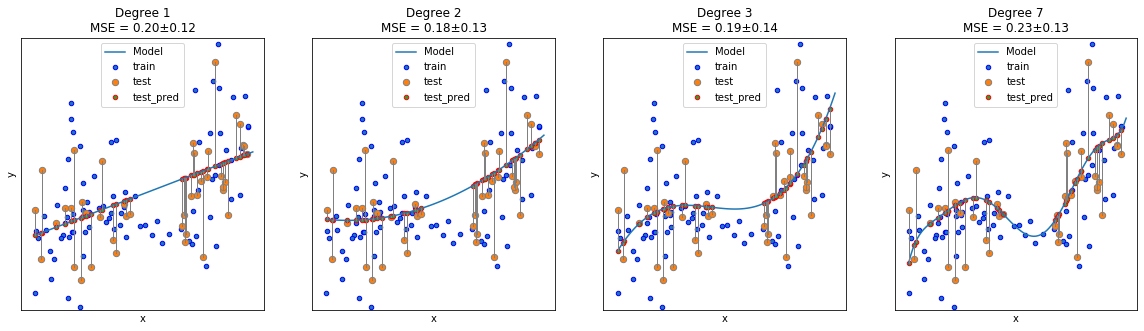

In [461]:
degrees = [1, 2, 3, 7]

plt.figure(figsize=(20, 5))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
models = []
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X_train[:, np.newaxis], y_train)
    models.append(pipeline)
    scores = cross_val_score(
        pipeline, X_test[:, np.newaxis], y_test, scoring="neg_mean_squared_error", cv=10
    )
    
    X_range = np.linspace(0.98*min(X), 1.02*max(X), 100)
    y_pred = pipeline.predict(X_range[:, np.newaxis])
    y_test_pred = pipeline.predict(X_test[:, np.newaxis])
    plt.plot(X_range, y_pred, label="Model")
    plt.scatter(X_train, y_train, edgecolor="b", s=20, label="train")
    for j in range(len(X_test)):
        plt.plot([X_test[j], X_test[j]], [y_test[j], y_test_pred[j]], 'k-', lw=1, color='grey')
    plt.scatter(X_test, y_test, edgecolor="grey", marker='o', s=40, label="test")
    plt.scatter(X_test, y_test_pred, edgecolor="r", s=20, label="test_pred")

    plt.xlabel("x")
    plt.ylabel("y")
    plt.ylim((10,13))
    plt.legend(loc="best")
    plt.title(
        "Degree {}\nMSE = {:.2f}±{:.2f}".format(
            degrees[i], -scores.mean(), scores.std()
        )
    )
plt.show()

Видно, что модель с многочленом регрессии в кубической степени   совсем не хуже чем в других моделях (не считая 7-ю степень - она была взята ради того, чтобы увидеть переобучение).

Построим гистограмму ошибок и посмотрим, похоже ли на нормальное распределение с нулевым мат.ожиданием

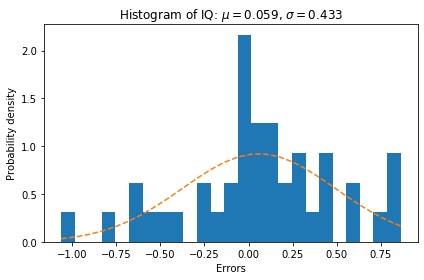

In [462]:
x_err = y_test_pred - y_test
num_bins = 25
mu = x_err.mean()
sigma=x_err.std()

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x_err, num_bins, density=1)

# add a 'best fit' line
y_err = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y_err, '--')
ax.set_xlabel('Errors')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of IQ: $\mu={:.3f}$, $\sigma={:.3f}$'.format(mu, sigma))

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()


Проверим гипотезу о распределении

In [463]:
k2, p = stats.normaltest(x_err)
alpha = 0.05
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.548932
The null hypothesis cannot be rejected


При таком значении p, получается, что нулевую гипотезу не можем отклонить, а значит, похоже на нормальное распределение.

Коэффициенты полинома кубической степени

In [464]:
coef = np.array([models[2].steps[1][1].intercept_, *models[2].steps[1][1].coef_ ])
coef

array([10.24896141,  0.99259117, -0.35165233,  0.03959292])

М-оценка:

$$\sum_{i=1}^{i=n}\rho(Y_i - k * X_i + c)$$

Формула Хьюбера:

$\rho(u) = 
    \begin{cases}
    \frac{u^2}{2}, &\text{|u| < k}\\
    k(|u| - \frac{k}{2}), &\text{|u| > k}
    \end{cases}
$

Формула Тьюки:

$\rho(u) = 
    \begin{cases}
    1 - (1 - (\frac{u}{k})^2)^3, &\text{|u| < k}\\
    1, &\text{|u| > k}
    \end{cases}
$

In [471]:
def cubic_func(coef, x):
    return coef[0] + coef[1]*x + coef[2]*x*x + coef[3]*x*x*x

def huber(x, delta):
    if abs(x) < delta:
        return x ** 2 / 2
    else:
        return delta * (abs(x) - delta / 2)

def tukey(x, delta):
    if abs(x) < delta:
        return (1 - (1 - (delta / x) ** 2) ** 3)
    else:
        return 1

def sum_huber(theta):
    res = 0
    for i in range(len(X_train)):
        res += huber(y_train[i] - cubic_func(theta, X_train[i]), 0.01)
    return res
    
def sum_tukey(theta):
    res = 0
    for i in range(len(X_train)):
        res += tukey(y_train[i] - cubic_func(theta, X_train[i]), 0.01)
    return res

## Huber

В fmin из numpy применяется метод Нелдера-Мида

In [472]:
coef_huber = optimize.fmin(sum_huber, coef)

Optimization terminated successfully.
         Current function value: 0.284243
         Iterations: 181
         Function evaluations: 308


Сравним коэффициенты обычного полинома и оптимизированного

In [473]:
coef

array([10.24896141,  0.99259117, -0.35165233,  0.03959292])

In [474]:
coef_huber

array([10.45581218,  0.76302494, -0.30039675,  0.03579389])

In [475]:
def f_huber(x):
    return cubic_func(coef_huber, x)

Из графика и вычисления оценок MSE видно, что оптимизированная модель чуть лучше предсказывает, чем исходная.

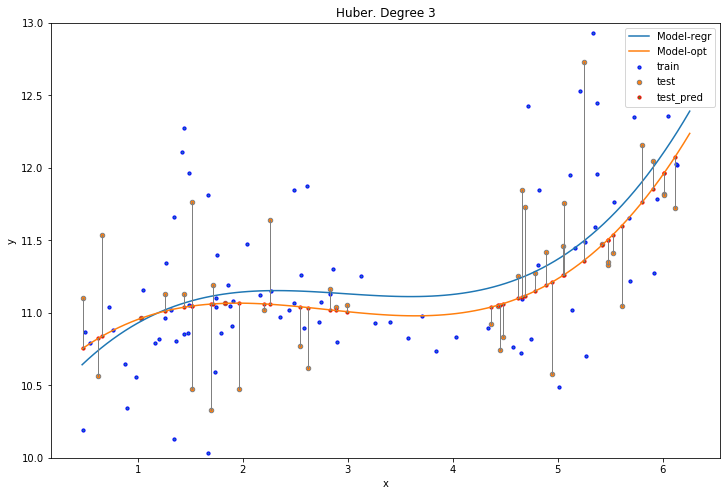

In [476]:
plt.figure(figsize=(12, 8))
X_range = np.linspace(0.98*min(X), 1.02*max(X), 100)
y_pred = models[2].predict(X_range[:, np.newaxis])
y_pred2 = list(map(f_huber, X_range))
y_test_pred_regr = models[2].predict(X_test[:, np.newaxis])
y_test_pred_opt = list(map(f_huber, X_test))
plt.plot(X_range, y_pred, label="Model-regr")
plt.plot(X_range, y_pred2, label="Model-opt")
#     plt.plot(X_test, true_fun(X_test), label="True function")
plt.scatter(X_train, y_train, edgecolor="b", s=10, label="train")
for j in range(len(X_test)):
    plt.plot([X_test[j], X_test[j]], [y_test[j], y_test_pred_opt[j]], 'k-', lw=1, color='grey')
plt.scatter(X_test, y_test, edgecolor="grey", marker='o', s=20, label="test")
plt.scatter(X_test, y_test_pred_opt, edgecolor="r", s=10, label="test_pred")

plt.xlabel("x")
plt.ylabel("y")
plt.ylim((10,13))
plt.legend(loc="best")
plt.title("Huber. Degree 3")
plt.show()

In [477]:
mean_squared_error(y_test, y_test_pred_regr)

0.18986734114685105

In [478]:
mean_squared_error(y_test, y_test_pred_opt)

0.17962502926498844

## Tukey

In [479]:
coef_tukey = optimize.fmin(sum_tukey, coef)

Optimization terminated successfully.
         Current function value: 84.000000
         Iterations: 27
         Function evaluations: 94


Сравним коэффициенты обычного полинома и оптимизированного

In [480]:
coef

array([10.24896141,  0.99259117, -0.35165233,  0.03959292])

In [481]:
coef_tukey

array([10.24896141,  1.04222073, -0.35165233,  0.03959292])

In [482]:
def f_tukey(x):
    return cubic_func(coef_tukey, x)

Из графика и оценок MSE видно, что оптимизация через Тьюки вышла хуже чем Хьюбера и обычной регрессии 

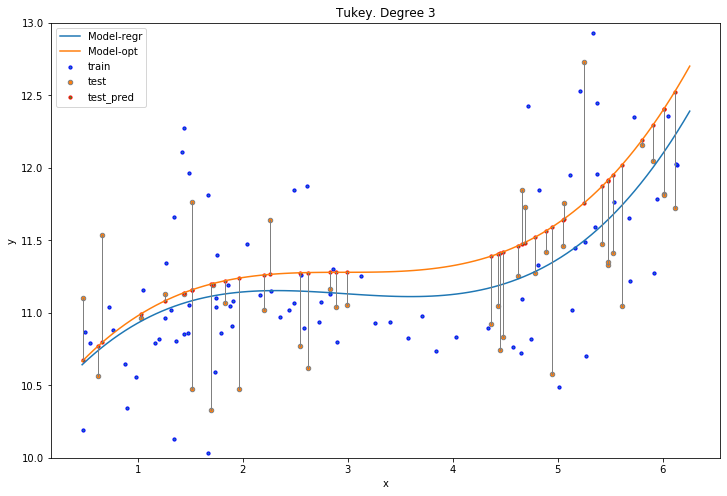

In [483]:
plt.figure(figsize=(12, 8))
X_range = np.linspace(0.98*min(X), 1.02*max(X), 100)
y_pred = models[2].predict(X_range[:, np.newaxis])
y_pred2 = list(map(f_tukey, X_range))
y_test_pred_regr = models[2].predict(X_test[:, np.newaxis])
y_test_pred_opt = list(map(f_tukey, X_test))
plt.plot(X_range, y_pred, label="Model-regr")
plt.plot(X_range, y_pred2, label="Model-opt")
#     plt.plot(X_test, true_fun(X_test), label="True function")
plt.scatter(X_train, y_train, edgecolor="b", s=10, label="train")
for j in range(len(X_test)):
    plt.plot([X_test[j], X_test[j]], [y_test[j], y_test_pred_opt[j]], 'k-', lw=1, color='grey')
plt.scatter(X_test, y_test, edgecolor="grey", marker='o', s=20, label="test")
plt.scatter(X_test, y_test_pred_opt, edgecolor="r", s=10, label="test_pred")

plt.xlabel("x")
plt.ylabel("y")
plt.ylim((10,13))
plt.legend(loc="best")
plt.title("Tukey. Degree 3")
plt.show()

In [484]:
mean_squared_error(y_test, y_test_pred_regr)

0.18986734114685105

In [485]:
mean_squared_error(y_test, y_test_pred_opt)

0.260864974494889